####################################################################
### Atelier "Comprendre et développer des CNN pour le traitement d'images"

#### **Partie 1 : Préparation des données** 

Dans cette introduction, nous allons apprendre à préparer les données pour qu'ils soient prêts à être utilisés pour un apprentissage par CNN


############################################################


#### **Préparation de l'environnement**

Nous utiliserons Pillow, NumPy, Matplotlib et torchvision pour les transformations.

- Pillow : librairie de manipulation d'images
- Numpy : librairie de manipulation de tableau
- torchvision : package de Pytorch spécialisé dans la computer vision

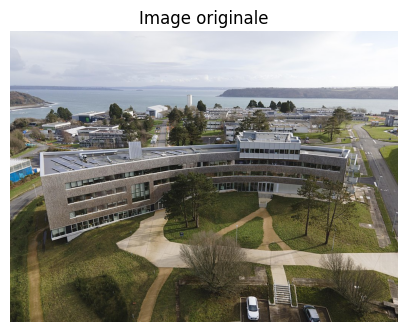

In [93]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import urllib.request

# Fonction pour afficher une image
def display_image(img, title=""):
    plt.figure(figsize=(5, 5))
    # Si l'image est un tenseur PyTorch, on la convertit en NumPy
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()  # De [C,H,W] à [H,W,C]
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Téléchargeons une image d'exemple depuis le web
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a6/Si%C3%A8ge_social_de_l%27Ifremer.jpg/1024px-Si%C3%A8ge_social_de_l%27Ifremer.jpg"
urllib.request.urlretrieve(url, "sample_image.png")

# Chargement de l'image
img = Image.open("sample_image.png").convert('RGB')
display_image(img, "Image originale")

#### **Etape 1 : redimensionnement**

Les CNN exigent de traiter des datasets dont toutes les images ont la même taille. Nous allons donc redimensionner l'image en taille 300x300 pour l'exercice. Pour ceci, nous allons utiliser l'utilitaire transforms de torchvision

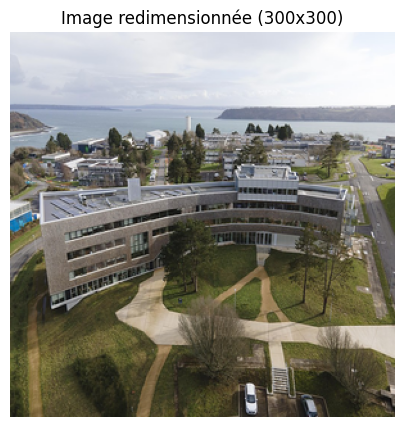

Dimensions de l'image redimensionnée : (300, 300, 3)


In [94]:
# Transformation de redimensionnement
resize_transform = transforms.Resize((300, 300), interpolation=transforms.InterpolationMode.LANCZOS)

# Application du redimensionnement
img_resized = resize_transform(img)
img_resized_array = np.array(img_resized)

# Affichage
display_image(img_resized_array, "Image redimensionnée (300x300)")

# Vérification des dimensions
print(f"Dimensions de l'image redimensionnée : {img_resized_array.shape}")

#### **Etape 2 : Normalisation des valeurs des pixels** 

L'intéret de cette normalisation réside dans l'aide qu'on apporte à l'optimiseur pour qu'il converge plus facilement lors de l'apprentissage.

Nous allons donc appliquer une transformation aux valeurs de pixels.

Pour chaque pixel de valeur v : v_nouveau = '(v - mean)/std


Le mean et la std appliqués sont généralement calculés sur les propriétés du dataset d'apprentissage (Exemple : Imagenet : mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225])

Dans notre cas, nous n'avons pas le dataset, on appliquera arbitrairement une mean de 0.5 et une std de 0.5

Valeurs avant normalisation (premiers 5 pixels, canal R) :
[226 229 234]
Valeurs après conversion en tenseur (premiers 5 pixels, canal R) :
tensor([0.8863, 0.8863, 0.8863, 0.8863, 0.8863])
Valeurs après normalisation ImageNet (premiers 5 pixels, canal R) :
tensor([1.2876, 1.2876, 1.2876, 1.2876, 1.2876])


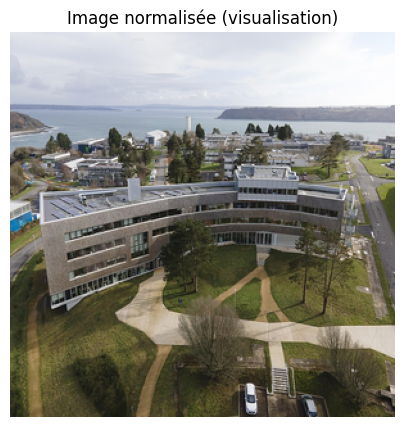

In [95]:
# Conversion en tenseur et normalisation simple (0-1)
to_tensor = transforms.ToTensor()  # Convertit en tenseur et normalise en [0, 1]
img_tensor = to_tensor(img_resized)

# Affichage des valeurs avant/après
print("Valeurs avant normalisation (premiers 5 pixels, canal R) :")
print(np.array(img_resized)[0, 0, :5])
print("Valeurs après conversion en tenseur (premiers 5 pixels, canal R) :")
print(img_tensor[0, 0, :5])

# Normalisation avec les statistiques d'ImageNet
normalize = transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.3,0.3,0.3])
img_normalized = normalize(img_tensor)

print("Valeurs après normalisation ImageNet (premiers 5 pixels, canal R) :")
print(img_normalized[0, 0, :5])

# Affichage (on dénormalise pour visualisation)
img_display = img_normalized.clone()
for c, m, s in zip(range(3), [0.5,0.5,0.5], [0.3,0.3,0.3]):
    img_display[c] = img_display[c] * s + m  # Inverse de la normalisation
display_image(img_display, "Image normalisée (visualisation)")

#### **Etape 3 : l'augmentation de données**

Les performances d'un modèle d'IA dépend fortement du nombre d'éléments du dataset d'entrainement. Il est donc souvent conseillé d'augmenter le jeu de données par des méthodes artificielles.

#Avec torchvision.transforms, on peut composer des augmentations aléatoires pour enrichir les données. Le but est d'augmenter le domaine de généralisation du futur modèle

Dans l'exemple suivant, on va créer :
 - une rotation aléatoire allant jusqu'à 40°
 - un flip horizontal
 - un décalage 
 - une déforamtion
 - un zoom


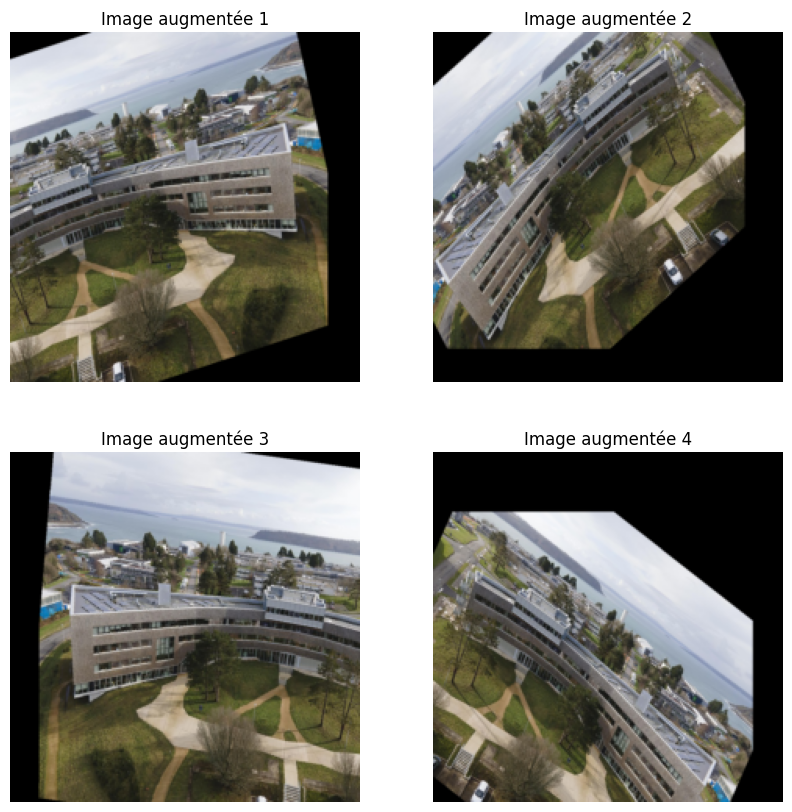

In [96]:
# Composition de transformations avec augmentation
augment_transform = transforms.Compose([
    transforms.RandomRotation(40),              # Rotation aléatoire jusqu'à 40°
    transforms.RandomHorizontalFlip(),          # Retournement horizontal
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2),  # Décalage et déformation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Zoom aléatoire
    transforms.ToTensor(),                      # Conversion en tenseur
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.3,0.3,0.3])  # Normalisation
])

# Génération de 4 images augmentées
plt.figure(figsize=(10, 10))
for i in range(4):
    img_augmented = augment_transform(img)
    # Dénormalisation pour affichage
    img_display = img_augmented.clone()
    for c, m, s in zip(range(3), [0.5,0.5,0.5], [0.3,0.3,0.3]):
        img_display[c] = img_display[c] * s + m
    plt.subplot(2, 2, i+1)
    plt.imshow(img_display.permute(1, 2, 0).numpy())
    plt.title(f"Image augmentée {i+1}")
    plt.axis('off')
plt.show()